# Data Analysis of the IRN

In [4]:
import typing

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import operator
import json
np.random.seed(7)
plt.style.use("ggplot")
COLOR = "teal"

# Converting JSON data to Dataframe/CSV

In [ ]:
with open('../scrapping/train_info2.json', 'r') as file:
    data = json.load(file)

## Preprocessing the table

In [5]:
#Run the below code if extraction done for the first time from json file.
# df = pd.DataFrame(data)
# df.head()
PATH = "../data/scrapped_df.csv"
df = pd.read_csv(PATH, header=0)

/var/folders/bn/t014mlfs2mq1px7y0rpdppjw0000gn/T/ipykernel_21592/2907075788.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH, header=0)


# Removing  the rows with null values

In [6]:
print("Rows with at least one NA value:", df.isna().any(axis=1).value_counts()[True])

Rows with at least one NA value: 9


In [7]:
# Since this is a small number, we can just drop these rows.
df.dropna(inplace=True, how="any")
# Reset the index as dropping rows deletes the index values creating jumps.
# If row 2 were deleted. The index would be 0, 1, 3, 4, ...
df.reset_index(drop=True, inplace=True)

In [8]:
df.columns

Index(['trainNumber', 'trainName', 'stationFrom', 'stationTo', 'station_code',
       'station_name', 'arrivalTime', 'departureTime', 'routeNumber',
       'haltTime', 'distance', 'dayCount', 'stnSerialNumber',
       'boardingDisabled'],
      dtype='object')

In [9]:
df.head()

,trainNumber,trainName,stationFrom,stationTo,station_code,station_name,arrivalTime,departureTime,routeNumber,haltTime,distance,dayCount,stnSerialNumber,boardingDisabled
0,12303,POORVA EXPRESS,HWH,NDLS,HWH,HOWRAH JN,--,08:00,1.0,--,0.0,1.0,1.0,False
1,12303,POORVA EXPRESS,HWH,NDLS,BWN,BARDDHAMAN JN,09:05,09:08,1.0,03:00,95.0,1.0,2.0,False
2,12303,POORVA EXPRESS,HWH,NDLS,DGR,DURGAPUR,09:57,09:59,1.0,02:00,158.0,1.0,3.0,False
3,12303,POORVA EXPRESS,HWH,NDLS,ASN,ASANSOL JN,10:32,10:37,1.0,05:00,200.0,1.0,4.0,False
4,12303,POORVA EXPRESS,HWH,NDLS,CRJ,CHITTARANJAN,11:00,11:02,1.0,02:00,225.0,1.0,5.0,False


In [81]:
# Change int columns to have int datatype
#Following code needs to be run while running the code on 2017 dataset collected from indianraliways.gov.in
df = df.astype({
    "trainNumber": int,
    "stnSerialNumber": int,
    "distance": int
})
# Change time columns to have time datatype
df["arrivalTime"] = pd.to_datetime(df["arrivalTime"], format="%H:%M").dt.time
df["departureTime"] = pd.to_datetime(df["departureTime"], format="%H:%M").dt.time

## Extract graph

In [10]:
STATION_CODE = 'station_code'
SOURCE_STATION = 'stationFrom'
DESTINATION_STATION = 'stationTo'
TRAIN_NAME = 'trainName'
TRAIN_NO = 'trainNumber'
DISTANCE = 'distance'


def generate_graph(railway_data, filter_nodes=None, distance_weighted=False, directed: bool = False):
    '''
    Genearte a graph where edges are trains. Two stations are connected
    if we can reach one station from the other without switching trains.
    '''
    # make an empty directed graph
    graph = nx.DiGraph() if directed else nx.Graph()
    stations = None

    # add all stations if there are none to filter
    if filter_nodes==None:
      stations = np.unique(railway_data[STATION_CODE])
    else:
      stations = filter_nodes
    
    graph.add_nodes_from(stations)
    
    # find all unique trains
    trains = np.unique(railway_data[TRAIN_NAME].astype('str'))
    
    # iterate over all trains
    for train_name in trains:

      # find out the stations the train visits
      train_route = railway_data.loc[railway_data[TRAIN_NAME] == train_name]
      stations_in_route = train_route[STATION_CODE].to_list()
      station_distances = train_route[DISTANCE].to_list()

      # make a connected graph out of all stations in route
      for source_station_itr in range(len(stations_in_route)):
        for destination_station_itr in range(source_station_itr+1, len(stations_in_route)):
          # Only add edge if node is present in the nodes to be filtered, or no node is to be filtered (i.e. add all)
          if filter_nodes==None \
            or stations_in_route[source_station_itr] in filter_nodes \
            or stations_in_route[destination_station_itr] in filter_nodes:

            if distance_weighted:
              # edge weight is the distance between the two nodes
              distance = int(station_distances[destination_station_itr]) \
                - int(station_distances[source_station_itr])
            else:
              # edge weight is the number of trains passing through the two stations
              distance = 1

            # if edge exists already then increment weight
            if graph.has_edge(
               stations_in_route[source_station_itr],
               stations_in_route[destination_station_itr]
            ):
                graph[stations_in_route[source_station_itr]][stations_in_route[destination_station_itr]]['weight'] += distance
            else:
                graph.add_edge(
                   stations_in_route[source_station_itr],
                   stations_in_route[destination_station_itr],
                   weight=distance,
                   label=train_name
                )
    return graph

## Analysis
Replicating the results from Ghosh, Saptarshi et al. “STATISTICAL ANALYSIS OF THE INDIAN RAILWAY NETWORK: A COMPLEX NETWORK APPROACH.” (2011).

In [11]:
irn = generate_graph(df, distance_weighted=False)
print(irn)

Graph with 3800 nodes and 311674 edges


In [21]:
avg_degree = 2 * irn.number_of_edges() / irn.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 164.03894736842105


In [22]:
print("#Connected components:", nx.number_connected_components(irn))

for cc in nx.connected_components(irn):
    print(len(cc))

#Connected components: 3
3792
6
2


In [23]:
# #! Don't run unless necessary. This takes more than half an hour.
# # Compute the weighted mean of average path length among the connected components.
cc_len = []
cc_shortest_path_len = []
for cc in nx.connected_components(irn):
    graph = nx.subgraph(irn, cc)
    avg_shortest_path = nx.average_shortest_path_length(graph)
    cc_len.append(len(cc))
    cc_shortest_path_len.append(avg_shortest_path)

In [24]:
print("Cluster size:", cc_len)
print("Cluster avg shortest path lengths:", cc_shortest_path_len)
print("Average shortest path length:", sum(cc_shortest_path_len) / len(cc_shortest_path_len))
print(
    "Weighted average shortest path length:",
    sum([i * j for i, j in zip(cc_len, cc_shortest_path_len)]) / sum(cc_len)
)

Cluster size: [3792, 6, 2]
Cluster avg shortest path lengths: [2.461654963398767, 1.0, 1.0]
Average shortest path length: 1.4872183211329224
Weighted average shortest path length: 2.45857779505477


In [25]:
print(cc_len)
print(cc_shortest_path_len)

[3792, 6, 2]
[2.461654963398767, 1.0, 1.0]


In [26]:
# Values obtained by running the two cells above.
#cc_len = [8059, 29, 12, 3, 17, 10, 17]
cc_len = [3792, 6, 2]
#cc_shortest_path_len = [2.884512707858718, 1.0369458128078817, 1.1363636363636365, 1.3333333333333333, 1.0, 1.2666666666666666, 1.0]
cc_shortest_path_len = [2.461654963398767, 1.0, 1.0]
print("Average shortest path length:", sum(cc_shortest_path_len) / len(cc_shortest_path_len))
print("Weighted average shortest path length:",
      sum([i * j for i, j in zip(cc_len, cc_shortest_path_len)]) / sum(cc_len))

Average shortest path length: 1.4872183211329224
Weighted average shortest path length: 2.45857779505477


# Data Analysis: Degree  and Strength Distribution

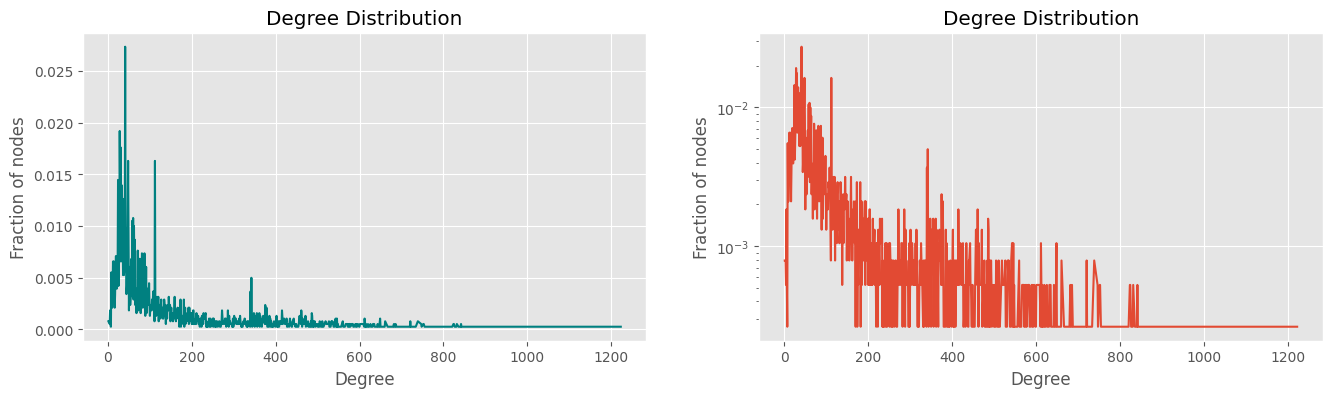

In [27]:
degree_sequence = sorted((d for n, d in irn.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree Distribution", figsize=(16, 4))

plt.subplot(1,2,1)
plt.plot(
    np.unique(degree_sequence, return_counts=True)[0],
    np.unique(degree_sequence, return_counts=True)[1] / irn.number_of_nodes(),
    color=COLOR,
)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")

plt.subplot(1,2,2)
plt.semilogy(
    np.unique(degree_sequence, return_counts=True)[0],
    np.unique(degree_sequence, return_counts=True)[1] / irn.number_of_nodes(),
)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")

plt.show()

The degree distribution is often quite noise. It is better to work with cumulative degree distribution.</br>
Cumulative degree distribution shows the fraction of nodes having at least degree k.

### Figure 2a

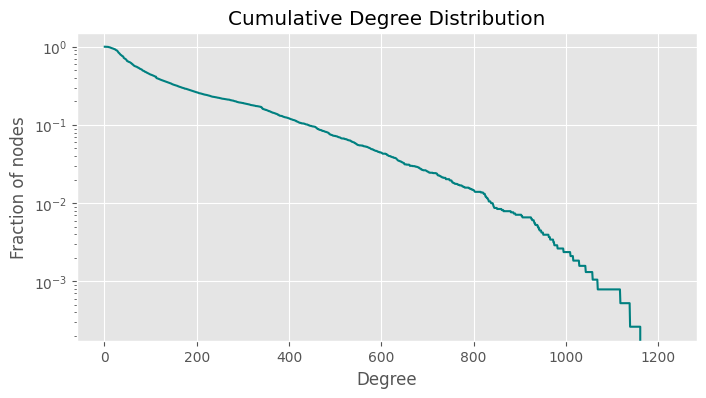

In [28]:
degree_sequence = sorted((d for n, d in irn.degree()))
unique, count = np.unique(degree_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

dmax = max(degree_sequence)
degrees = list(range(1, dmax))
degree_dist = []
# skip 0.
for i in range(1, dmax):
    if i in unique:
        degree_dist.append(count_dict[i])
    else:
        degree_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_degree_dist = np.cumsum(degree_dist[::-1])[::-1] / irn.number_of_nodes()

plt.figure(figsize=(8, 4))
plt.semilogy(degrees, cumulative_degree_dist, color=COLOR)

plt.title("Cumulative Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")
plt.show()

### Figure 2b

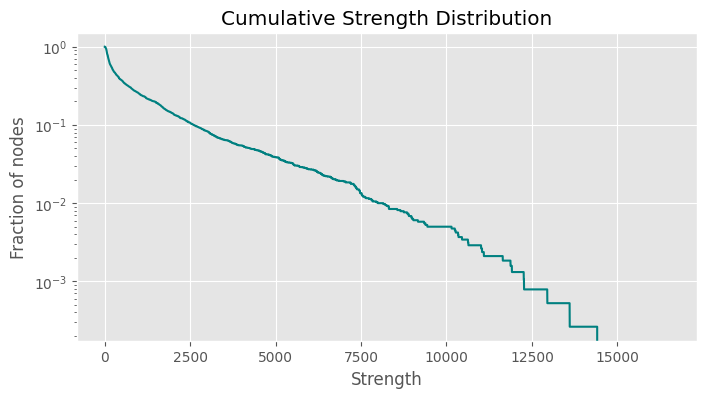

In [29]:
strength_sequence = sorted((d for n, d in irn.degree(weight="weight")))
unique, count = np.unique(strength_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

smax = max(strength_sequence)
strengths = list(range(1, smax))
strength_dist = []
# skip 0.
for i in range(1, smax):
    if i in unique:
        strength_dist.append(count_dict[i])
    else:
        strength_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_strength_dist = np.cumsum(strength_dist[::-1])[::-1] / irn.number_of_nodes()

plt.figure(figsize=(8, 4))
plt.semilogy(strengths, cumulative_strength_dist, color=COLOR)

plt.title("Cumulative Strength Distribution")
plt.xlabel("Strength")
plt.ylabel("Fraction of nodes")
plt.show()

In [30]:
print("Top 10 stations based on #journeys:")
sorted(
    ((n,d) for n, d in irn.degree(weight="weight")),
    key=lambda x: x[1],
    reverse=True
)[:10]

Top 10 stations based on #journeys:


[('ET', 16494),
 ('PNBE', 14409),
 ('BZA', 13602),
 ('CNB', 12947),
 ('ADI', 12266),
 ('HWH', 12258),
 ('LKO', 11911),
 ('JBP', 11871),
 ('BRC', 11644),
 ('VGLJ', 11091)]

# Data Analysis: Edge Distribution

### Figure 3a

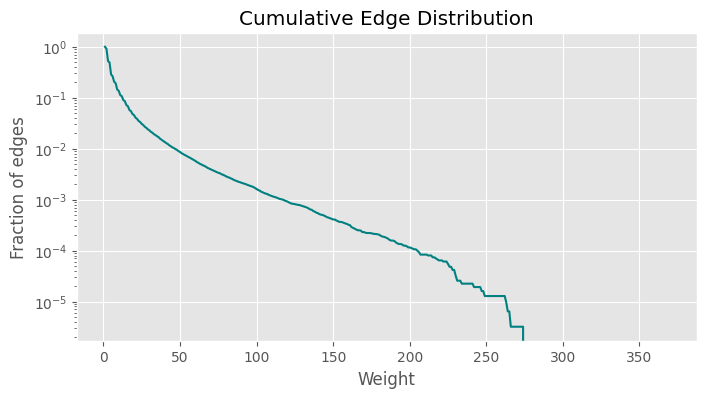

In [31]:
edge_sequence = sorted((irn.edges[edge]["weight"] for edge in irn.edges()))
unique, count = np.unique(edge_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

wmax = max(edge_sequence)
weights = list(range(1, wmax))
weight_dist = []
# skip 0.
for i in range(1, wmax):
    if i in unique:
        weight_dist.append(count_dict[i])
    else:
        weight_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_weight_dist = np.cumsum(weight_dist[::-1])[::-1] / irn.number_of_edges()

plt.figure(figsize=(8, 4))
plt.semilogy(weights, cumulative_weight_dist, color=COLOR)
# plt.plot(weights, cumulative_weight_dist, color=COLOR)

plt.title("Cumulative Edge Distribution")
plt.xlabel("Weight")
plt.ylabel("Fraction of edges")
plt.show()

In [32]:
print("Top 10 edges based on weight:")
sorted(
    ((edge, irn.edges[edge]["weight"]) for edge in irn.edges()),
    key = lambda x: x[1],
    reverse=True
)[:10]

Top 10 edges based on weight:


[(('BRC', 'ST'), 370),
 (('ET', 'JBP'), 274),
 (('BBS', 'KUR'), 265),
 (('ADI', 'ANND'), 263),
 (('JTJ', 'KPD'), 262),
 (('ADI', 'BRC'), 248),
 (('JBP', 'STA'), 246),
 (('ADI', 'ST'), 241),
 (('CNB', 'PRYJ'), 233),
 (('BBS', 'CTC'), 230)]

### Figure 3b

In [33]:
degree_strength_dict = {}
for node in irn.nodes():
    degree = nx.degree(irn, node)
    strength = nx.degree(irn, node, weight="weight")
    try:
        degree_strength_dict[degree][0] += strength
        degree_strength_dict[degree][1] += 1
    except KeyError:
        degree_strength_dict[degree] = [strength, 1]

degree_strength_list = [(k, v[0] / v[1]) for k, v in degree_strength_dict.items()]
degree_strength_list = sorted(degree_strength_list, key=lambda x: x[0])

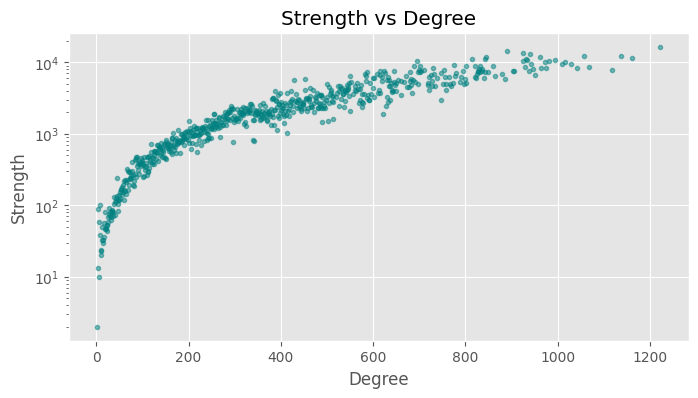

In [34]:
plt.figure(figsize=(8, 4))
xticks = [i[0] for i in degree_strength_list]
yticks = [i[1] for i in degree_strength_list]
plt.semilogy(xticks, yticks, marker=".", linewidth=0, alpha=0.5, color=COLOR)

plt.title("Strength vs Degree")
plt.ylabel("Strength")
plt.xlabel("Degree")

plt.show()

### Figure 4a

In [35]:
# iterate over edges
prod_vs_weights = []
for edge in irn.edges():
    # save edge weight
    weight = irn.edges[edge]["weight"]
    # save product of src, dest nodes
    product = irn.degree(edge[0]) * irn.degree(edge[1])
    prod_vs_weights.append((product, weight))

prod_vs_weights = sorted(prod_vs_weights, key=lambda x: x[0])

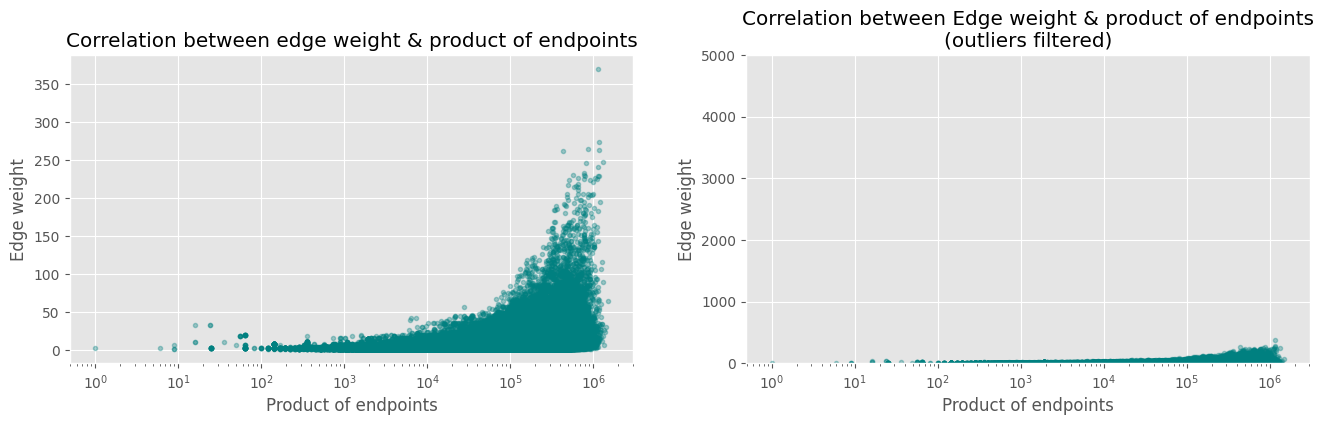

In [36]:
xticks = [i[0] for i in prod_vs_weights]
yticks = [i[1] for i in prod_vs_weights]
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.semilogx(xticks, yticks, marker=".", alpha=0.33, linewidth=0, color=COLOR)
plt.title("Correlation between edge weight & product of endpoints")
plt.xlabel("Product of endpoints")
plt.ylabel("Edge weight")

plt.subplot(1, 2, 2)
plt.semilogx(xticks, yticks, marker=".", alpha=0.33, linewidth=0, color=COLOR)
plt.ylim(0, 5000)
plt.title("Correlation between Edge weight & product of endpoints\n(outliers filtered)")
plt.xlabel("Product of endpoints")
plt.ylabel("Edge weight")

plt.show()

In [37]:
prod_weight_dict = {}
for edge in irn.edges():
    # save edge weight
    weight = irn.edges[edge]["weight"]
    # save product of src, dest nodes
    product = irn.degree(edge[0]) * irn.degree(edge[1])
    try:
        prod_weight_dict[product][0] += weight
        prod_weight_dict[product][1] += 1
    except KeyError:
        degree_strength_dict[degree] = [weight, 1]

prod_weight_list = [(k, v[0] / v[1]) for k, v in prod_weight_dict.items()]
prod_weight_list = sorted(degree_strength_list, key=lambda x: x[0])

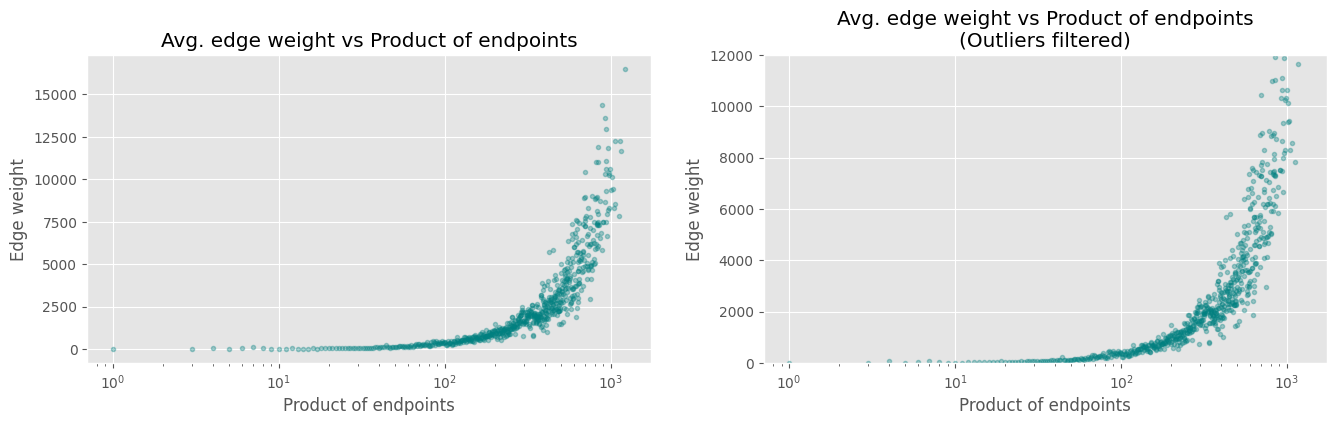

In [38]:
xticks = [i[0] for i in prod_weight_list]
yticks = [i[1] for i in prod_weight_list]
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.semilogx(xticks, yticks, marker=".", alpha=0.33, linewidth=0, color=COLOR)
plt.title("Avg. edge weight vs Product of endpoints")
plt.xlabel("Product of endpoints")
plt.ylabel("Edge weight")

plt.subplot(1, 2, 2)
plt.semilogx(xticks, yticks, marker=".", alpha=0.33, linewidth=0, color=COLOR)
plt.ylim(0, 12000)
plt.title("Avg. edge weight vs Product of endpoints\n(Outliers filtered)")
plt.xlabel("Product of endpoints")
plt.ylabel("Edge weight")

plt.show()

# 4 Clustering Coefficient

In [39]:
Clustering_Coefficient = nx.average_clustering(irn)
print("The Clustering Coefficent of the Graph: ", Clustering_Coefficient)

The Clustering Coefficent of the Graph:  0.7328562988435579


In [40]:
def clustering_coefficient(nw):
    clustering_nodes = nx.clustering(nw)
    degrees = nw.degree()
    degrees_unique = list(set([y for (x,y) in degrees]))
    clustering_dict = {}

    for deg in degrees_unique:
        kdegree = [x for (x,y) in degrees if y==deg]
        kdegree_nodes = len(kdegree)

        cluster_sum = 0
        for n in kdegree_nodes:
            cluster_sum += clustering_nodes[n]

        clustering_dict[deg] = cluster_sum/kdegree_nodes

    return clustering_dict

     

In [41]:
deg_clustering = clustering_coefficient(irn)

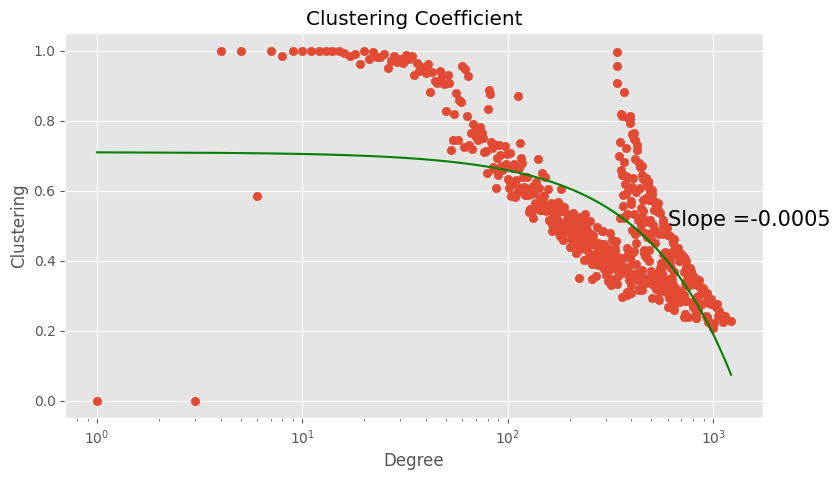

In [42]:
deg_cval = (list(deg_clustering.keys()))
Degree_Clustering_Values = (list(deg_clustering.values()))

plt.figure(figsize=(9, 5))
plt.scatter(deg_cval, Degree_Clustering_Values)

plt.xlabel("Degree")  
plt.ylabel("Clustering")

m, b = np.polyfit(np.array(deg_cval), np.array(Degree_Clustering_Values), 1)
#plt.semilogx(xticks, yticks, marker=".", alpha=0.33, linewidth=0, color=COLOR)
plt.semilogx(np.array(deg_cval), m*np.array(deg_cval) + b, color = 'g')

plt.text(600, 0.5, "Slope =" + str(round(m, 4)), fontsize=15)

plt.title("Clustering Coefficient")

plt.show()

# 6. Degree correlation

In [75]:
def degree_degree_correlation(nw):
    unique_degrees = list(set([y for (x,y) in nw.degree()]))
    corr_dict = {}

    for deg in unique_degrees:
        kdegree_nodes = [x for (x,y) in nw.degree() if y==deg]
        total_k_nodes = len(kdegree_nodes)

        deg_sum = 0
        for node in kdegree_nodes:
            nbrs = []
            for n in nw.neighbors(node):
                nbrs.append(n)
            sumdeg = 0
            for nbr in nbrs:
                sumdeg = sumdeg+nw.degree[nbr]

            if(len(nbrs)>0):
                avg_deg = sumdeg/len(nbrs)
            else:
                avg_deg = 0

        corr_dict[deg] = (deg_sum+avg_deg)/total_k_nodes
    return corr_dict

In [76]:
degree_correlation = degree_degree_correlation(irn)

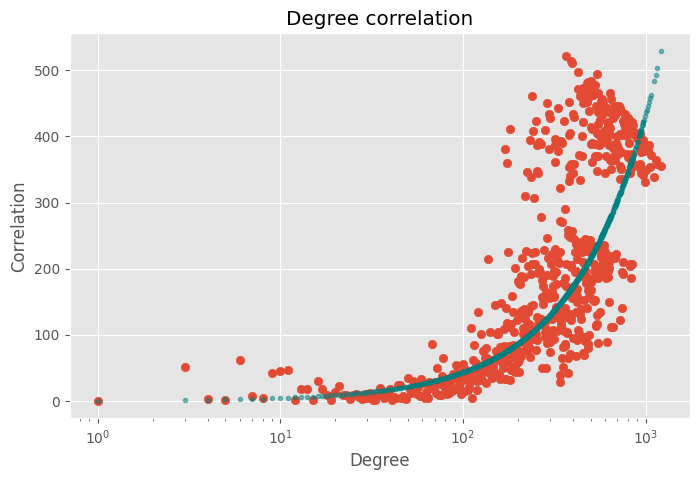

In [77]:
deg_vals = (list(degree_correlation.keys()))
deg_corr_vals = (list(degree_correlation.values()))

plt.figure(figsize=(8, 5))

plt.scatter(deg_vals, deg_corr_vals)

plt.xlabel("Degree")  
plt.ylabel("Correlation")

m, b = np.polyfit(np.array(deg_vals), np.array(deg_corr_vals), 1)
#plt.plot(np.array(deg_vals), m*np.array(deg_vals) + b, color = 'b')
plt.semilogx(np.array(deg_vals), m*np.array(deg_vals), marker=".", alpha=0.5, linewidth=0, color=COLOR)

plt.title("Degree correlation")

plt.show()

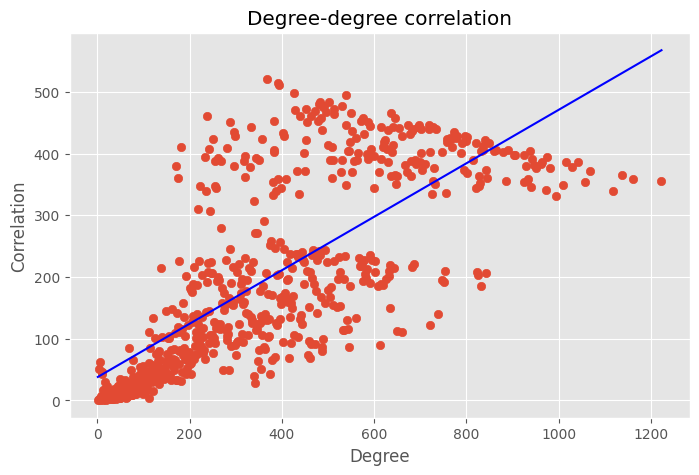

In [78]:
plt.figure(figsize=(8, 5))

plt.scatter(deg_vals, deg_corr_vals)

plt.xlabel("Degree")  
plt.ylabel("Correlation")

m, b = np.polyfit(np.array(deg_vals), np.array(deg_corr_vals), 1)
plt.plot(np.array(deg_vals), m*np.array(deg_vals) + b, color = 'b')

plt.title("Degree-degree correlation")

plt.show()

# 3.3

In [44]:
# Calculate node degrees and strengths
degree_dict = dict(irn.degree())
strength_dict = dict(nx.degree(irn, weight='weight'))

# Create arrays to store degrees and strengths
degrees = np.array([degree_dict[node] for node in irn.nodes()])
strengths = np.array([strength_dict[node] for node in irn.nodes()])

# Calculate the correlation between degree and strength
correlation = np.corrcoef(degrees, strengths)[0, 1]

print(f"Strength-Degree Correlation: {correlation}")

Strength-Degree Correlation: 0.9204836903867881


# Centrality Measures

In [17]:
def get_top_stations_centrality(centrality_measure,railway_data):
    #get top 10 items based on centrality measures
    centrality = sorted(centrality_measure.items(),key=operator.itemgetter(1),reverse=True)[:10]
    stations = []
    station_codes = []
    for item in centrality:
        station_code = item[0]
        station_codes.append(station_code)
        stations.append((railway_data.loc[railway_data['station_code'] == station_code]['station_name'].to_list()[0], item[1]))
  
    return stations,station_codes

def print_stations_getxy(stn_name,stn_val,centrality_stations):
    for item in centrality_stations:
        stn_name.append(item[0])
        stn_val.append(item[1])
        print("\t",item[0],"\t\t",item[1])

    return stn_name,stn_val


In [13]:
deg_centrality = nx.degree_centrality(irn)
between_centrality = nx.betweenness_centrality(irn)
close_centrality = nx.closeness_centrality(irn)





In [18]:
deg_stn_name = []
deg_stn_val = []
deg_centrality_stations,deg_station_codes = get_top_stations_centrality(deg_centrality, df)
print("Top stations in the Indian Railway System (Degree Centrality)\n\n")
print("\tSTATION NAME\t\t DEGREE CENTRALITY")
print()
deg_stn_name, deg_stn_val = print_stations_getxy(deg_stn_name,deg_stn_val,deg_centrality_stations)

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 ITARSI JN 		 0.3219268228481179
	 VADODARA JN 		 0.3056067386154251
	 AHMEDABAD JN 		 0.29955251381942616
	 GHAZIABAD 		 0.2940247433535141
	 MATHURA JN 		 0.28112661226638586
	 HOWRAH JN 		 0.2782311134509081
	 AGRA CANTT 		 0.2742827059752566
	 ANAND JN 		 0.27059752566464856
	 NEW DELHI 		 0.26717557251908397
	 KALYAN JN 		 0.26559620952882335


In [19]:
print(deg_station_codes)

['ET', 'BRC', 'ADI', 'GZB', 'MTJ', 'HWH', 'AGC', 'ANND', 'NDLS', 'KYN']


In [25]:
     
bet_stn_name = []
bet_stn_val = []
bet_centrality_stations,bet_station_codes = get_top_stations_centrality(between_centrality, df)
print("Top stations in the Indian Railway System (Betweenness Centrality)\n\n")
print("\tSTATION NAME\t\t BETWEENNESS CENTRALITY")
print()
bet_stn_name, bet_stn_val = print_stations_getxy(bet_stn_name,bet_stn_val,bet_centrality_stations)

Top stations in the Indian Railway System (Betweenness Centrality)


	STATION NAME		 BETWEENNESS CENTRALITY

	 VISAKHAPATNAM 		 0.01816805643148913
	 HOWRAH JN 		 0.017327441150252754
	 SEALDAH 		 0.013703360266404584
	 VIJAYAWADA JN 		 0.01251222281669336
	 MATHURA JN 		 0.011749238416423115
	 GHAZIABAD 		 0.01168142863199226
	 GUNTAKAL JN 		 0.010713967667721478
	 SURAT 		 0.010698079194942428
	 BHOPAL  JN 		 0.010500951136221702
	 V LAKSHMIBAIJHS 		 0.010282571809245876


In [26]:
cls_stn_name = []
cls_stn_val = []
cls_centrality_stations,cls_station_codes = get_top_stations_centrality(close_centrality, df)
print("Top stations in the Indian Railway System (Closeness Centrality)\n\n")
print("\tSTATION NAME\t\t CLOSENESS CENTRALITY")
print()
cls_stn_name, cls_stn_val = print_stations_getxy(cls_stn_name,cls_stn_val,cls_centrality_stations)

Top stations in the Indian Railway System (Closeness Centrality)


	STATION NAME		 CLOSENESS CENTRALITY

	 ITARSI JN 		 0.5923922402973009
	 VADODARA JN 		 0.5815552415893256
	 AHMEDABAD JN 		 0.5805734878051815
	 NEW DELHI 		 0.5737059215254113
	 HOWRAH JN 		 0.573184370687661
	 AGRA CANTT 		 0.5724904428781119
	 MATHURA JN 		 0.5716253923449022
	 GHAZIABAD 		 0.5714526958517467
	 ANAND JN 		 0.5704187042428472
	 BHOPAL  JN 		 0.5699889779325844


In [29]:



def get_plot(x_col,y_col,description):
    data = {'Station_Name':x_col,'Centrality':y_col}
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=df, orient='v', color='blue')
    plt.xlabel('Stations')
    plt.ylabel(description)
    plt.title(description+' of Stations')
    plt.show()




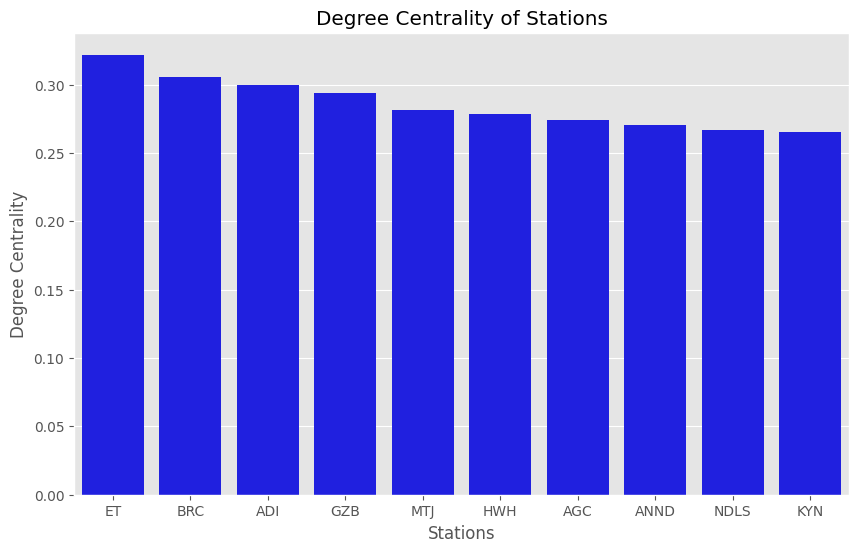

In [30]:
get_plot(deg_station_codes,deg_stn_val,'Degree Centrality')

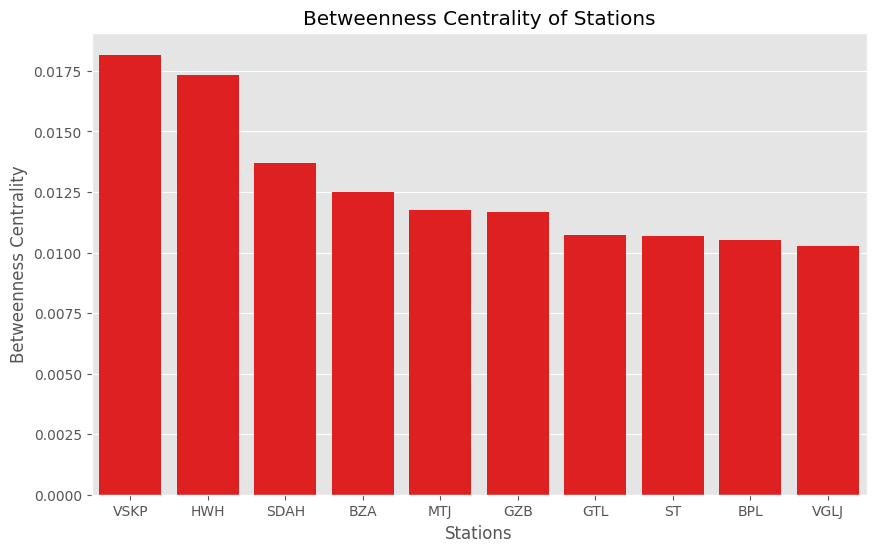

In [80]:
get_plot(bet_station_codes,bet_stn_val,'Betweenness Centrality')

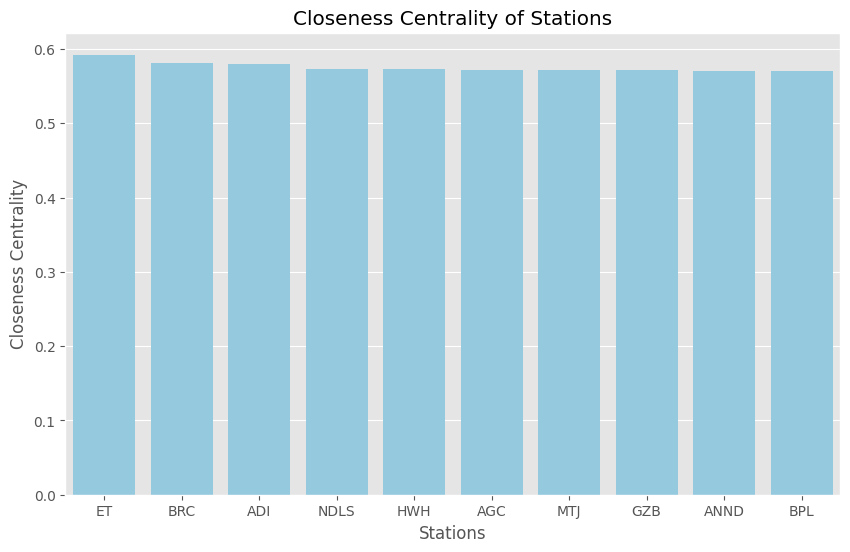

In [70]:
get_plot(cls_station_codes,cls_stn_val,'Closeness Centrality')